### Selection of pairs
For a successful pairs traing strategy it is paramount to select suitable pairs. In the literature a multitude of different machine learning approaches have been developed.
We explore a selection process based on the following ideas:
- Use principal component analsysis(PCA) to reduce the dimensions of the data
- Apply OPTICS to cluster the different time series
- Select cointegrated time series that pass the Earle-Grenger test for cointegration
- Ensure that the time series have strong mean-reversion properties by computing the Hurst exponent, the half-life time and counting the nuber of mean crossings.

In [1]:
import sys
sys.path.append("../TradingSystem") # go to parent dir

In [2]:
# Ignore panda warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import yfinance as yf
import numpy as np

In [3]:
# Define a list of cryptocurrency tickers
crypto = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD', 'DOGE-USD', 'ETC-USD', 'XLM-USD', 'AAVE-USD', 'EOS-USD', 'XTZ-USD', 'ALGO-USD', 'XMR-USD', 'KCS-USD',
          'MKR-USD', 'BSV-USD', 'RUNE-USD', 'DASH-USD', 'KAVA-USD', 'ICX-USD', 'LINA-USD', 'WAXP-USD', 'LSK-USD', 'EWT-USD', 'XCN-USD', 'HIVE-USD', 'FTX-USD', 'RVN-USD', 'SXP-USD', 'BTCB-USD']

# Define a list of bank tickers
bank = ['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'DB', 'UBS', 'BBVA', 'SAN', 'ING', 'BNPQY', 'HSBC', 'SMFG', 'PNC', 'USB', 'BK', 'STT', 'KEY', 'RF', 'HBAN', 'FITB', 'CFG',
        'BLK', 'ALLY', 'MTB', 'NBHC', 'ZION', 'FFIN', 'FHN', 'UBSI', 'WAL', 'PACW', 'SBCF', 'TCBI', 'BOKF', 'PFG', 'GBCI', 'TFC', 'CFR', 'UMBF', 'SPFI', 'FULT', 'ONB', 'INDB', 'IBOC', 'HOMB']

# Define a list of stock tickers
stocks = ['AAPL', 'AMZN', 'GOOG', 'IBM', 'MSFT', 'NFLX', 'NVDA', 'TSLA', 'V', 'WMT']

# Combine all tickers into a single list
tickers = stocks + crypto + bank

# Define the start and end dates for the data download
startDate = '2021-01-01'
endDate = '2023-10-31'

# Create a dictionary to store the downloaded data
dataMap = {}

# Iterate over each ticker and download the data
for ticker in tickers:
    dataMap[ticker] = yf.download(ticker, start=startDate, end=endDate, progress=False)


1 Failed download:
['PACW']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [4]:
from sklearn.preprocessing import MinMaxScaler

# Clean the data
totalTime = (pd.to_datetime(endDate) - pd.to_datetime(startDate)).days

# Create a date range for the data
dateRange = pd.date_range(start=startDate, end=endDate, freq='D')
returnData = pd.DataFrame(index=dateRange)
priceData = pd.DataFrame(index=dateRange)

# Iterate over each ticker in the dataMap
for ticker in dataMap:

    # Skip if the dataMap for the ticker is None or has less than half the total time
    if dataMap[ticker] is None or len(dataMap[ticker]) < (totalTime / 2):
        continue

    # Extract the 'Adj Close' column from the dataMap and select the last totalTime days
    df = dataMap[ticker][['Adj Close']]
    df = df[-totalTime:]

    # Reindex the time series to match the date range and fill in any blanks (Not Numbers)
    df = df.reindex(dateRange)
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.interpolate(method='linear')
    df['Adj Close'].fillna(method='pad', inplace=True)
    df['Adj Close'].fillna(method='bfill', inplace=True)

    # Check if there are any NaN values or infinite values in the 'Adj Close' column
    assert not np.any(np.isnan(df['Adj Close'])) and not np.any(np.isinf(df['Adj Close']))

    # Calculate the daily returns
    df['Returns'] = (df['Adj Close'] - df['Adj Close'].shift(1)) / df['Adj Close'].shift(1)
    df['Returns'].fillna(method='pad', inplace=True)
    df['Returns'].fillna(method='bfill', inplace=True)

    # Store the 'Returns' and 'Adj Close' columns in the returnData and priceData DataFrames
    returnData[ticker] = df['Returns']
    priceData[ticker] = df['Adj Close']


### Dimension reduction
Currently we are investigating 87 time series in a 1033 day period. The resulting 87 x 1033 matrix is computationally ineffective. Thus we apply principal component analysis to reduce the dimensions of the data.
We choose the number of components by plotting all different possibilities.

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# At various points we need to work with scaled data
# We mainly use standard normalization and MinMax scaling in this notebook
scaler = StandardScaler()
returnDataScaled = pd.DataFrame(index = returnData.index)
priceDataScaled = pd.DataFrame(index = returnData.index)
returnDataScaled[returnData.columns] = scaler.fit_transform(returnData[returnData.columns])
priceDataScaled[priceData.columns] = MinMaxScaler().fit_transform(priceData[priceData.columns])
pca = PCA()
X_pca = pca.fit(returnDataScaled.transpose())

Text(0.5, 1.0, 'Explained variatition in PCA')

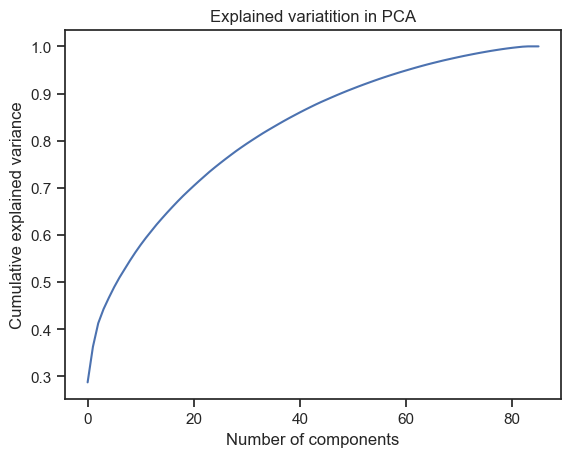

In [6]:
#To choose the number of components for PCA we plot how much variance is explained for how many components
sns.set_style('ticks')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained variatition in PCA')

### Clustering the time series

After the principal component analysis the time series has 80 dimensions. 
We now use ``Ordering points to identify the clustering strutcure'' (OPTICS) to sort the time series into clusters. 
In order to graph the clusters we use t-SNE to project the data to $2$ dimensions.

Text(0.5, 1.0, 't-SNE projection of the time series clusters')

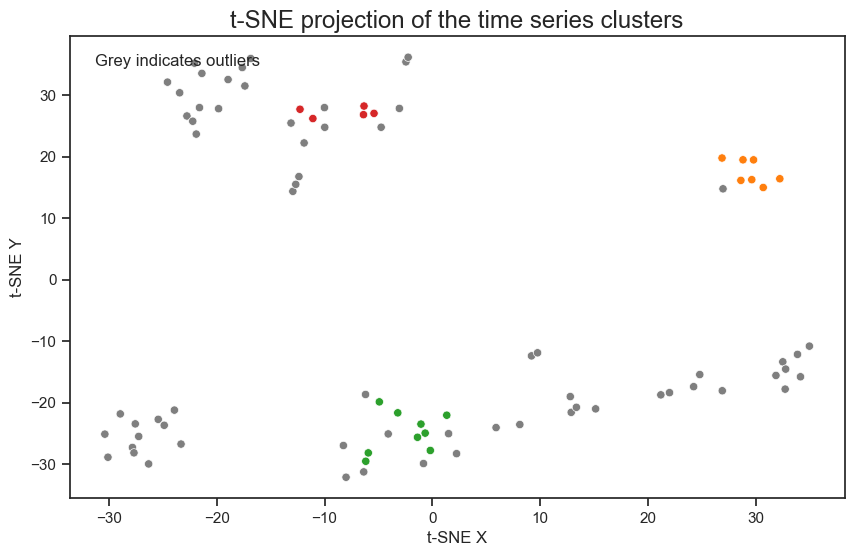

In [7]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS



# Apply principal component analysis with 80 components
num_components = 80
seriesPCA = PCA(num_components)  
seriesPCA = PCA(num_components).fit_transform(returnDataScaled.transpose().values)


seriesOPTICS = OPTICS(min_samples=4).fit(seriesPCA)


# Create a new data frame that contains the information to which cluster each time series belongs

# Currently each time series is a column, but we need to work with rows
clusterData = returnDataScaled.transpose()

#Apply t-SNE to project the data to 2 dimensions
clusterEmbedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(clusterData)
clusterData['Clusters'] = seriesOPTICS.labels_

clusterData['t-SNE X'] = [x for x,_ in clusterEmbedded]
clusterData['t-SNE Y'] = [y for _,y in clusterEmbedded]




# Plotting the clusters
palette = {
    -1: 'tab:grey',
    0: 'tab:green',
    1: 'tab:orange',
    2: 'tab:red',
    3: 'tab:blue'
}
plt.figure(figsize=(10,6))
sns.scatterplot(data=clusterData, x='t-SNE X', y='t-SNE Y', hue='Clusters', palette = palette)
plt.legend([],[], frameon=False)
plt.figtext(0.15, 0.83, 'Grey indicates outliers')
plt.title("t-SNE projection of the time series clusters" ,size='x-large')

### Visualizing the clusters 
OPTICs separates the data into three clusters.  The remaining stocks are noise and cannot be fitted into clusters using OPTICS.
(Note that the data is high-dimensional and the t-SNE projection can be misleading since points might look close after projection.)
The first cluster consists of cryptos, the other two consists of banks.
In order to compare the different cluster, we  plot the time series  separated by clusters.
(For plotting we normalized using MaxMinScaler so that all assets have the same scale.)

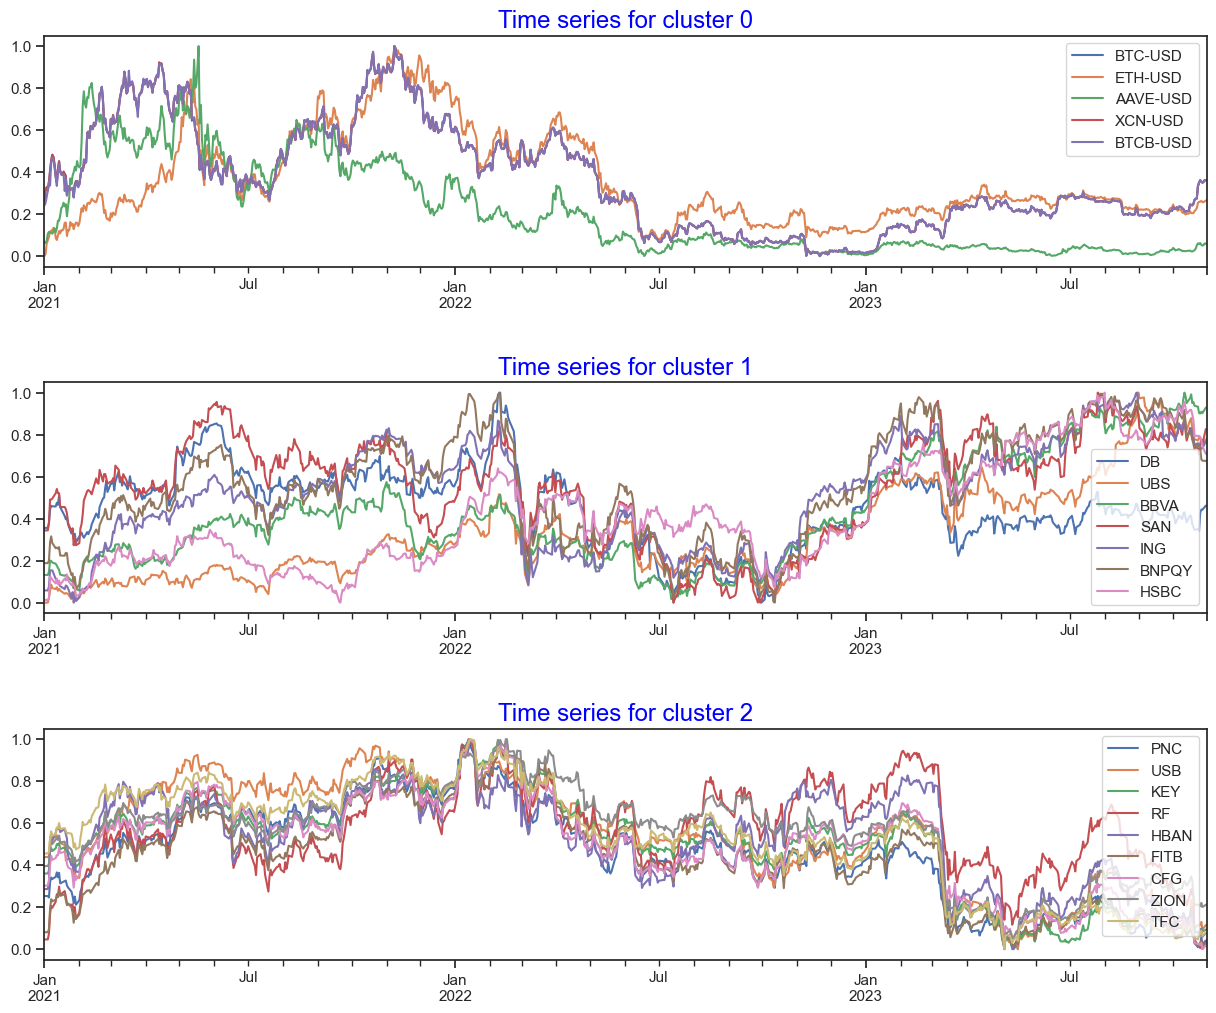

In [8]:
stockClusters = [ list(clusterData.loc[clusterData['Clusters'] == i].index) for i in range(2,-2,-1)]

# Define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)


# Draw the time series for each cluster, except for the noise "cluster"
for i, clust in enumerate(stockClusters[:-1]):
    
    ax = plt.subplot(3,1, i+1)
    # Use the adjusted close prices for the stocks
    df = priceDataScaled[clust]
    
    df.plot(ax=ax)
    
    # Add title
    ax.set_title("Time series for cluster {}".format(i),size='x-large',color='blue') 

### The search for cointegrated pairs
In the next step we further analyze the assets in each cluster. The goal is to find pairs whose time series has strong-mean reversion effects. Our strategy to identify mean-reversion iterates through all possible pairs in a cluster and has four components.
- Apply the Engle-Grenger test for cointegration. We accept a pair as cointegrated if the resulting p-Value is less then 0.03
- Determine the Hurst exponent of a pair. A Hurst exponent  $<1/2$ indicates a mean-reversing series.
- Compute the half-life time (under the assuption that the spreads are cointegrated and follow an Ornstein-Uhlenbeck process)
- Count the number of times the spread crosses its mean as a further indicator for mean reversion.

### Cointegration test using Engle-Grenger
For each cluster we now analyze which pairs are cointegrated. Two time series $X_t, Y_t$ are cointegrated if 
\begin{equation}
Y_t- \alpha X_t
\end{equation}
is a stationary process for some constant $\alpha$.
THe test proceeds in several steps. First c

In [9]:
from itertools import combinations
from statsmodels.tsa.stattools import coint

# Generate combinations of pairs from a list
comb = combinations([1, 2, 3], 2)
scaler = MinMaxScaler()

# Generate pairs for testing cointegration from stockClusters list
pairs = [comb for cluster in stockClusters[:-1] for comb in combinations(cluster, 2)]

pValues = []
admissiblePairs = []

# Iterate over each pair of tickers
for pair in pairs:
    ticker1, ticker2 = pair
    
    # Scale the price data for each ticker using MinMaxScaler
    scaled1 = scaler.fit_transform(priceData[ticker1].values.reshape(-1, 1))
    scaled2 = scaler.fit_transform(priceData[ticker2].values.reshape(-1, 1))
    
    # Calculate the p-value for cointegration test
    pVal = coint(scaled1, scaled2)[1]
    
    # Check if the p-value is less than 0.05 for admissibility
    if pVal < 0.05:
        admissiblePairs.append(pair)
        pValues.append(pVal)

# Update the pairs list with admissible pairs
pairs = admissiblePairs

# Create a DataFrame to store the pairs and their corresponding p-values
pairData = pd.DataFrame(index=pairs)
pairData['P Values'] = pValues

After the cointegration test we have isolated the following pairs:

In [10]:
for pair in pairs:
    print(pair)

('BTC-USD', 'XCN-USD')
('BTC-USD', 'BTCB-USD')
('XCN-USD', 'BTCB-USD')
('PNC', 'USB')
('PNC', 'KEY')
('PNC', 'FITB')
('PNC', 'TFC')
('KEY', 'FITB')
('HBAN', 'CFG')


### Plotting the spreads
To get a feeling for how closely related theremaining  time series of the pairs are, we are now going to plot their spread.
For the remaining pairs we compute the spread acoording to 
\begin{equation}
\text{ spread} = \ln(S_A)-h\ln(S_B),
\end{equation}
where 
- $S_A, S_B$ are the stock prices,
- $h = \sigma(\ln(r_A))/\sigma(\ln(r_B))$ for the returns $r_A,r_B$.







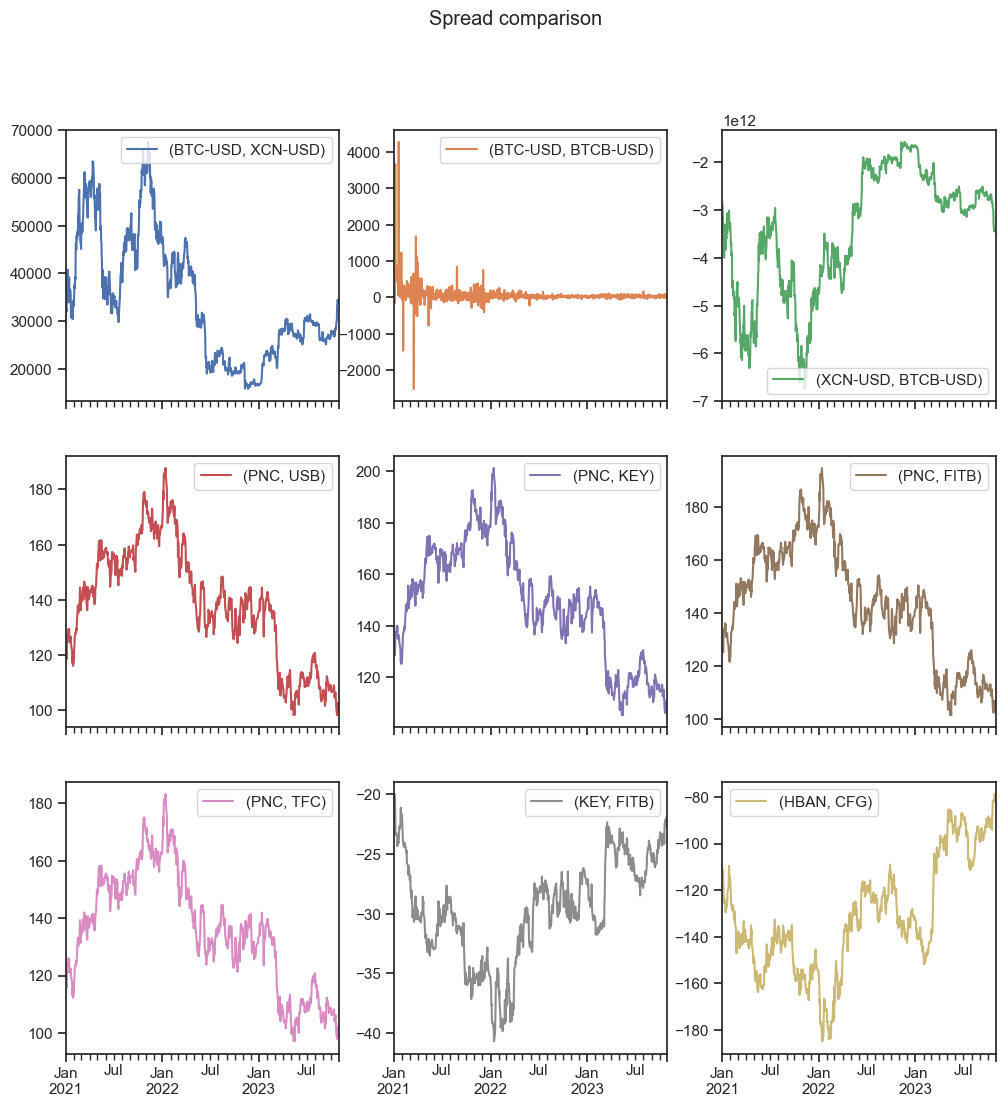

In [11]:
spread = pd.DataFrame(index=priceData.index)
logSpread = pd.DataFrame(index=priceData.index)

# Iterate over each pair of admissible tickers
for k, pair in enumerate(pairs):
    ticker1, ticker2 = pair
    
    # Calculate the hedge ratio using linear regression
    h = np.polyfit(priceData[ticker1], priceData[ticker2], deg=1)[0]
    
    # Calculate the spread between the two tickers
    spread[pair] = priceData[ticker1] - h * priceData[ticker2]

# Set the style and plot the spreads
sns.set_style('ticks')
spread.plot(subplots=True, layout=(3, 3), sharex=True, figsize=(12, 12), title='Spread comparison')
plt.show()

Next we implement our three technical indicators, Hurst exponent, half-life time and number of mean crossings.


In [12]:
def hurstExponent(ts):
    """
    Returns the Hurst Exponent of the time series  ts 

    Parameters
    ----------
    ts : `numpy.array` or `pandas.Series`
        Time series upon which the Hurst Exponent will be calculated

    Returns
    -------
    'float'
        The Hurst Exponent from the linear regression output
    """
    if(type(ts)== pd.Series):
        ts = ts.values

    # Create the range of lag values
    lags = range(2, 100)
   
    # Calculate the array of the variances of the lagged differences
    variances = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    slope = np.polyfit(np.log(lags), np.log(variances), 1)[0]

    # Return the Hurst exponent from the polyfit output
    return slope*2



pairData['Hurst'] = [hurstExponent(spread[pair]) for pair in pairs] 


In [13]:
from scipy import stats



def halfLife(ts):
    """
    Returns the  half-life time of the time series, an indicator for how fast the time series returns to the mean

    Parameters
    ----------
    ts : `numpy.array` or `pandas.Series`
        Time series upon which the half life time will be calculated

    Returns
    -------
    'float'
        The half life time as output from linear regression
    """
    # Calculate the lagged values of the time series
    lag = ts.shift(1)

    # Fit a linear regression model to the lagged values and the time series
    h = np.polyfit(lag[1:], ts[1:], deg=1)[0]

    # Calculate  half-life time
    return -np.log(2) / np.log(h)



pairData['Half-life'] = [halfLife(spread[pair]) for pair in pairs]



In [14]:
def meanCrossings(ts):
    ''' Returns the number of times the time series 'ts' crosses its mean.

    Parameters
    ----------
    ts :'pandas.Series'
        Time series for which we count the number of crossings

    Returns
    -------
    'int'
        The number of times the time series crosses its mean
    '''


    df = pd.DataFrame()
    df['Values'] = ts
    df['Lag']=df['Values'].shift(1)
    # The shifted series has NaN values, so we drop them
    df = df.dropna()
    dfMean = df['Values'].mean()
    # Compare values to the previous day and only collect values where the mean is crossed
    df = df[((df['Values'] > dfMean) & (df['Lag'] < dfMean)) | ((df['Values'] <dfMean) & (df['Lag'] >dfMean)) ]
    return len(df.index)


pairData['Mean crossings'] = [meanCrossings(spread[pair]) for pair in pairs]


We can now compare the different indicators to determine which pairs are the most promising for mean-reversion

                         P Values     Hurst   Half-life  Mean crossings
(BTC-USD, XCN-USD)   2.142719e-21  0.504175  128.298211              18
(XCN-USD, BTCB-USD)  1.072630e-16  0.503927  121.711713              22
(BTC-USD, BTCB-USD)  1.758407e-14 -0.024361    0.499584             353
(HBAN, CFG)          1.813568e-02  0.493849  250.805471              20
(PNC, USB)           2.562849e-02  0.427085  211.936522              32
(PNC, FITB)          2.926906e-02  0.431278  229.431937              32
(KEY, FITB)          3.366990e-02  0.435938   82.743939              48
(PNC, TFC)           3.785742e-02  0.425776  196.739466              40
(PNC, KEY)           4.829845e-02  0.432683  224.229673              36


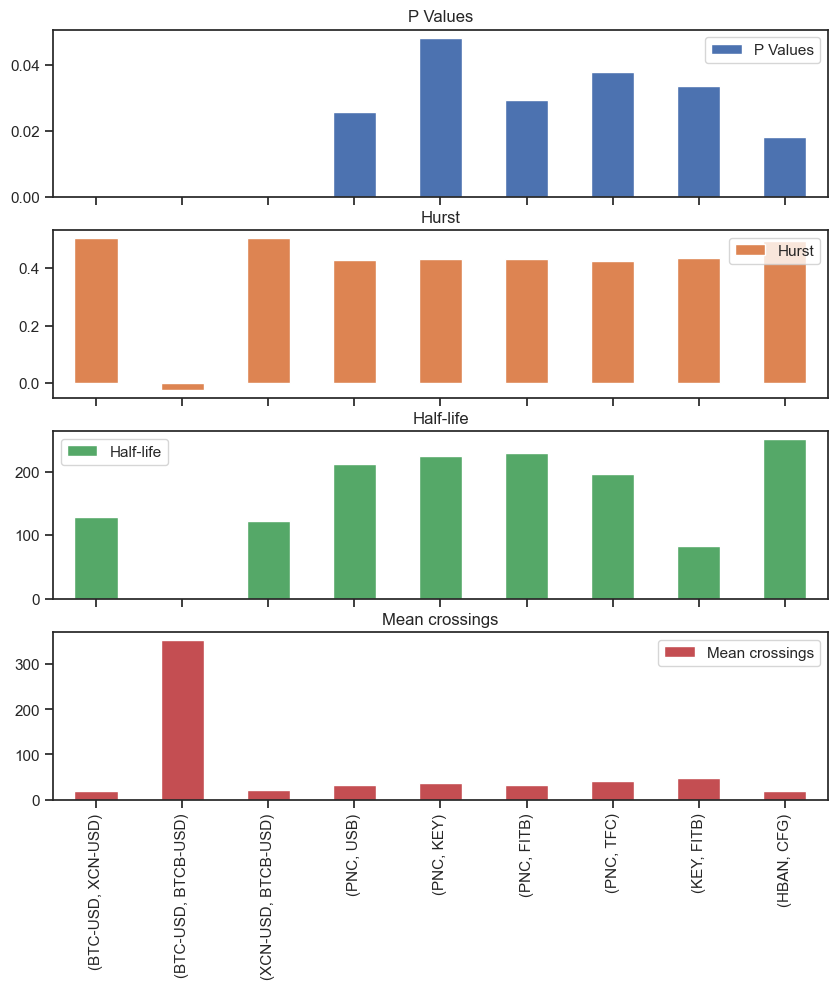

In [15]:
print(pairData.sort_values(by = 'P Values'))

pairData.plot(subplots= True, kind = 'bar', figsize = (10,10))
plt.show()

Of the different pairs we choose KeyCorps('KEY') and FifthThird Bank('FITB') due to a short half-life time and high number of mean crossings.

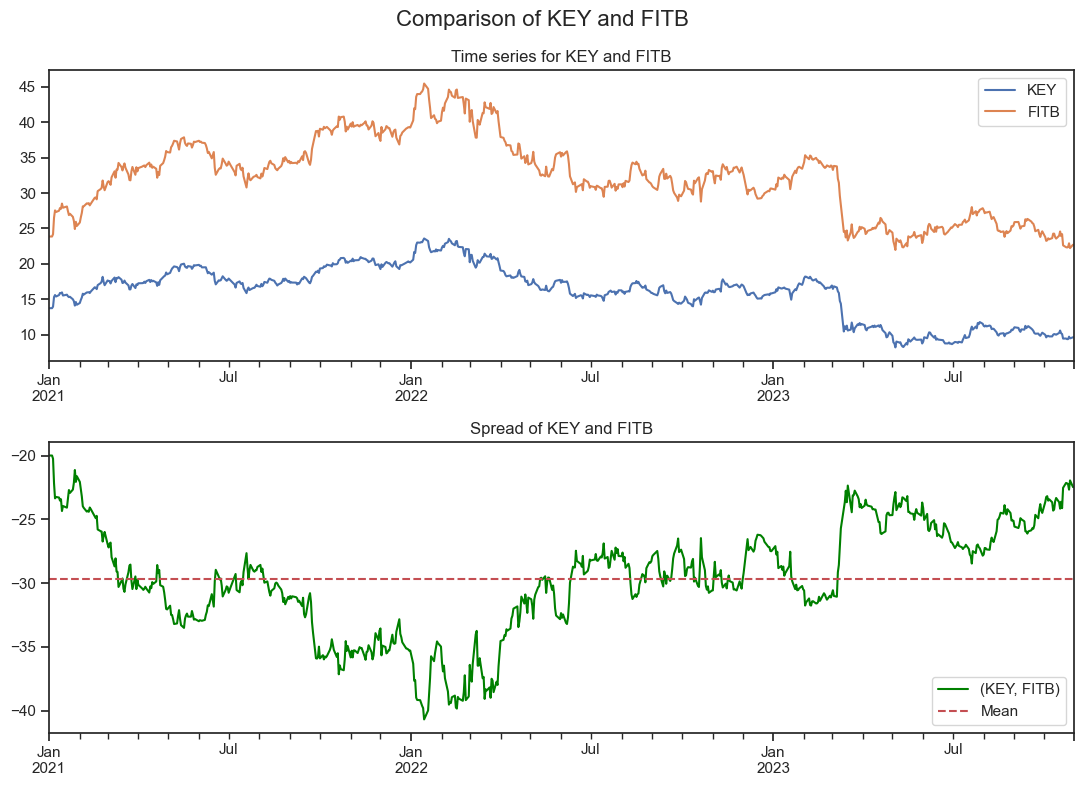

In [16]:
pair = ('KEY', 'FITB')

# Set the style and create subplots for visualization
sns.set_style('ticks')
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(11, 8))
fig.suptitle("Comparison of {} and {}".format(pair[0], pair[1]), fontsize=16)

# Plot the time series data for the selected pair
priceData[[pair[0], pair[1]]].plot(ax=axes[0])
axes[0].legend()
axes[0].set_title('Time series for {} and {}'.format(pair[0], pair[1]))

# Plot the spread data for the selected pair
spread[('KEY', 'FITB')].plot(ax=axes[1], color='green')

# Add a horizontal line representing the mean of the spread
plt.axhline(y=spread[pair].mean(), color='r', linestyle='dashed', label='Mean')
axes[1].legend(loc="lower right")
axes[1].set_title('Spread of {} and {}'.format(pair[0], pair[1]))

# Adjust layout and display the plots
fig.tight_layout()
plt.show()
